# Modeling Notebook

In [29]:
#importing basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Pycaret
from pycaret.classification import *
sns.set()
import warnings
warnings.filterwarnings('ignore')

In [30]:
# Reading the dataset
data = pd.read_csv('../dataset/cardio_train.csv',sep=';')
# Check the data
data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


#  Data Preprocessing

* I will drop column 'id' as it is irrelevant to target variable.
* Transform age column into years instead of days.
* Gender feature should not be categorized into 1 and 2 because 2 is always numerically bigger than 1, the model would take into account that and give a bigger ratio to one gender for having a disease. So, I will make that binary.
* I will check and drop duplicates.
* i would check for outliars

In [31]:
# There is no mising value in the data.
print(f"Missing values are present: {data.isnull().sum().any()}")

Missing values are present: False


In [32]:
data.drop('id',axis=1,inplace=True)
data.age = np.round(data.age/365.25,decimals=1)
data.gender = data.gender.replace(2,0)

In [33]:
data.duplicated().sum()

674

In [34]:
data.drop_duplicates(inplace=True)

## Checking for Outliers

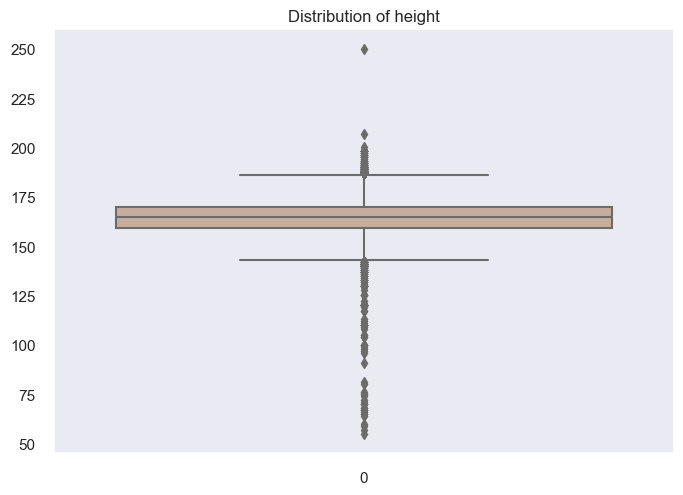

In [7]:
sns.set_style('dark')
sns.boxplot(data.height,palette='pink')
plt.title('Distribution of height');

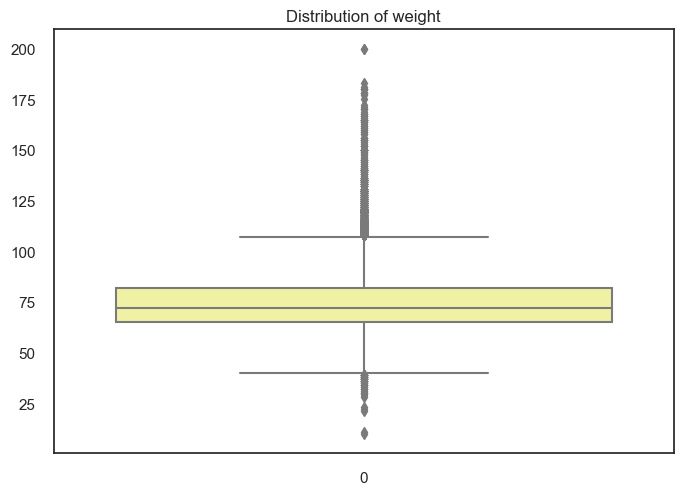

In [8]:
sns.set_style('white')
sns.boxplot(data.weight,palette='terrain')
plt.title('Distribution of weight');

I will remove extremely rare cases of height and weight. As data is quite big, there will be no problem while modelling.

In [35]:
data.drop(data [(data ['height'] > data ['height'].quantile(0.975)) | (data ['height'] < data ['height'].quantile(0.025))].index,inplace=True)
data.drop(data [(data ['weight'] > data ['weight'].quantile(0.975)) | (data ['weight'] < data ['weight'].quantile(0.025))].index,inplace=True)

There are many outliers in height and weight features. I combine both of these into a new feature bmi.

In [36]:
data["bmi"] = (data["weight"]/ (data["height"]/100)**2).round(1)

Now, I will remove outliers and abrupt blood pressure values.

In [37]:
data.drop(data[(data['ap_hi'] > data['ap_hi'].quantile(0.975)) | (data['ap_hi'] < data['ap_hi'].quantile(0.025))].index,inplace=True)
data.drop(data[(data['ap_lo'] > data['ap_lo'].quantile(0.975)) | (data['ap_lo'] < data['ap_lo'].quantile(0.025))].index,inplace=True)

In [38]:
#creating dummy variables for categorical column
data['cholesterol']=data['cholesterol'].map({ 1: 'normal', 2: 'above normal', 3: 'well above normal'})
data['glucose']=data['gluc'].map({ 1: 'normal', 2: 'above normal', 3: 'well above normal'})
data.drop(['height','weight','gluc'],axis=1,inplace=True)
data.head()

,age,gender,ap_hi,ap_lo,cholesterol,smoke,alco,active,cardio,bmi,glucose
0,50.4,0,110,80,normal,0,0,1,0,22.0,normal
1,55.4,1,140,90,well above normal,0,0,1,1,34.9,normal
2,51.6,1,130,70,well above normal,0,0,0,1,23.5,normal
3,48.2,0,150,100,normal,0,0,1,1,28.7,normal
4,47.8,1,100,60,normal,0,0,0,0,23.0,normal


In order to demonstrate the predict_model function on unseen data, a sample of 5960 rows has been withheld from the original dataset to be used for predictions. This should not be confused with a train/test split as this particular split is performed to simulate a real life scenario. Another way to think about this is that these 5960 records were not available at the time when the machine learning experiment was performed.

In [39]:
# Creating a test dataset from the orginal dataset
dataset=data.sample(frac=0.9, random_state=20)
data_unseen = data.drop(dataset.index)

dataset.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)
data_unseen.drop(columns=['cardio'],inplace=True)

print('Data for Modeling: ' + str(data.shape))
print("-----------------------------------------------------------")
print('Unseen Data For Predictions: ' + str(data_unseen.shape))
print("-----------------------------------------------------------")

Data for Modeling: (59598, 11)
-----------------------------------------------------------
Unseen Data For Predictions: (5960, 10)
-----------------------------------------------------------


###  Setting up the Environment in pipeline

The setup() function initializes the environment in pycaret and creates the transformation pipeline to prepare the data for modeling and deployment<br>

The PyCaret's setup is made with 90% of data samples and just use one function (`setup`) from the module.<br>
It's possible configure with variuos options, as data pre-processing, feature engineering, etc. The easy and efficient of PyCaret buy a lot of time when prototyping models.<br>
Each setup is an experiment and for this problem, is used the following options:
* Feature Selection with permutation importance techniques.
* Outliers Removal.
* Features Removal based on Multicollinearity.
* 70% of samples for Train and 30% for test.

In [40]:
exp01 = setup(data=dataset, 
              target="cardio", 
              session_id=20,  
              transformation=True,
              normalize=True,
              silent=True
                )

,Description,Value
0,session_id,20
1,Target,cardio
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(53638, 11)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,6
8,Ordinal Features,False
9,High Cardinality Features,False


Once the setup has been successfully executed it prints the information grid which contains several important pieces of information. Most of the information is related to the pre-processing pipeline which is constructed when setup() is executed

### Comparing All Models

 This function trains all 15 models in the model library and scores them using stratified cross validation for metric evaluation. The output prints a score grid that shows average Accuracy, Recall, Precision, F1, Kappa, and MCC  along with training times.<br>

 Comparing all models to evaluate performance is the recommended starting point for modeling once the setup is completed (unless you exactly know what kind of model you need, which is often not the case)

In [41]:
top_model = compare_models(fold=10,
                            sort="Accuracy",
                            n_select=1,
                            turbo=True,
                            )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7270,0.7916,0.6768,0.7439,0.7087,0.4529,0.4548,0.3500
gbc,Gradient Boosting Classifier,0.7269,0.7932,0.6791,0.7424,0.7093,0.4527,0.4544,2.3980
lr,Logistic Regression,0.7220,0.7819,0.6731,0.7375,0.7038,0.4429,0.4446,2.3960
ada,Ada Boost Classifier,0.7216,0.7874,0.6376,0.7568,0.6920,0.4414,0.4468,0.7650
ridge,Ridge Classifier,0.7215,0.0000,0.6698,0.7384,0.7024,0.4418,0.4437,0.0500
lda,Linear Discriminant Analysis,0.7215,0.7818,0.6698,0.7384,0.7024,0.4418,0.4437,0.1230
svm,SVM - Linear Kernel,0.7182,0.0000,0.6528,0.7447,0.6938,0.4350,0.4401,0.2140
knn,K Neighbors Classifier,0.6859,0.7325,0.6664,0.6849,0.6755,0.3713,0.3714,0.8080
rf,Random Forest Classifier,0.6859,0.7431,0.6733,0.6824,0.6777,0.3714,0.3716,2.0540
et,Extra Trees Classifier,0.6715,0.7177,0.6596,0.6672,0.6633,0.3426,0.3427,2.2320


As we can see Gradient Boosting Classifier alogrithm performs better than other alogrithm even though Light Gradient Boosting Machine tops the table for having the best accuracy, when considering other metrics Gradient Boosting Classifier out perfroms other algorthism in terms of AUC, Recall and F1 <br>The score grid printed above highlights the highest performing metric for comparison purposes only

### Creating a Model
 As the name suggests this function trains and evaluates a model using cross validation that can be set with fold parameter. The output prints a score grid that shows Accuracy, Recall, Precision, F1, Kappa and MCC by fold.

In [42]:
top_models=create_model("gbc",fold=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7321,0.7953,0.6777,0.7520,0.7129,0.4630,0.4652
1,0.7369,0.8009,0.6875,0.7546,0.7195,0.4727,0.4746
2,0.7212,0.7881,0.6813,0.7318,0.7057,0.4414,0.4424
3,0.7262,0.7869,0.6694,0.7464,0.7058,0.4512,0.4536
4,0.7318,0.7965,0.6830,0.7484,0.7142,0.4626,0.4643
5,0.7249,0.7881,0.6933,0.7318,0.7120,0.4491,0.4497
6,0.7259,0.7964,0.6868,0.7368,0.7109,0.4509,0.4519
7,0.7086,0.7802,0.6629,0.7208,0.6906,0.4161,0.4174
8,0.7312,0.7982,0.6792,0.7496,0.7126,0.4613,0.4633


### Model Optimazation 
The tune_model function is a random grid search of hyperparameters over a pre-defined search space.
Time to tune the model. The `choose_better` argument get the best model between the tuned and best model.

In [43]:
# hyperparameter optimization 
tuned_model = tune_model(estimator=top_models,
                         fold=10,
                         optimize="Accuracy", 
                         choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7313,0.7935,0.6652,0.7577,0.7085,0.4612,0.4646
1,0.7356,0.7993,0.6728,0.7607,0.7141,0.4698,0.4729
2,0.7236,0.7892,0.6743,0.7393,0.7053,0.4460,0.4477
3,0.7244,0.7877,0.6526,0.7527,0.6990,0.4472,0.4511
4,0.7324,0.7951,0.6688,0.7572,0.7103,0.4634,0.4664
5,0.7300,0.7881,0.6802,0.7467,0.7119,0.4588,0.4606
6,0.7243,0.7959,0.6667,0.7447,0.7035,0.4473,0.4497
7,0.7102,0.7812,0.6422,0.7339,0.6850,0.4188,0.4220
8,0.7307,0.7989,0.6661,0.7560,0.7082,0.4600,0.4632


## Ensemble a Model
Ensemble learning is a machine learning paradigm where multiple models (often called “weak learners”) are trained to solve the same problem and combined to get better results. The main hypothesis is that when weak models are correctly combined we can obtain more accurate and/or robust models.
<br>
 There are various techniques for ensembling, These include Bagging and Boosting (Read More). The ensemble_model() function in PyCaret which ensembles the trained base estimators using the method defined in the method parameter.

 https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205

In [44]:
bagged_model = ensemble_model(tuned_model, fold=5,choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7350,0.7970,0.6665,0.7634,0.7117,0.4686,0.4723
1,0.7250,0.7888,0.6643,0.7473,0.7033,0.4487,0.4514
2,0.7282,0.7918,0.6764,0.7459,0.7095,0.4553,0.4572
3,0.7202,0.7892,0.6631,0.7396,0.6993,0.4391,0.4414
4,0.7309,0.8000,0.6645,0.7572,0.7078,0.4603,0.4637
Mean,0.7279,0.7934,0.6670,0.7507,0.7063,0.4544,0.4572
Std,0.0050,0.0044,0.0049,0.0085,0.0044,0.0100,0.0105


Notice how ensembling has improved the Acuracy of Gradient Boosting Classifier. 

In [45]:
best_model = bagged_model 
print(f"Model: {type(best_model)}")

Model: <class 'sklearn.ensemble._bagging.BaggingClassifier'>


### Model Evalution metrics
Before model finalization, the plot_model function can be used to analyze the performance across different aspects such as AUC, confusion_matrix, decision boundary etc. This function takes a trained model object and returns a plot based on the test / hold-out set. 

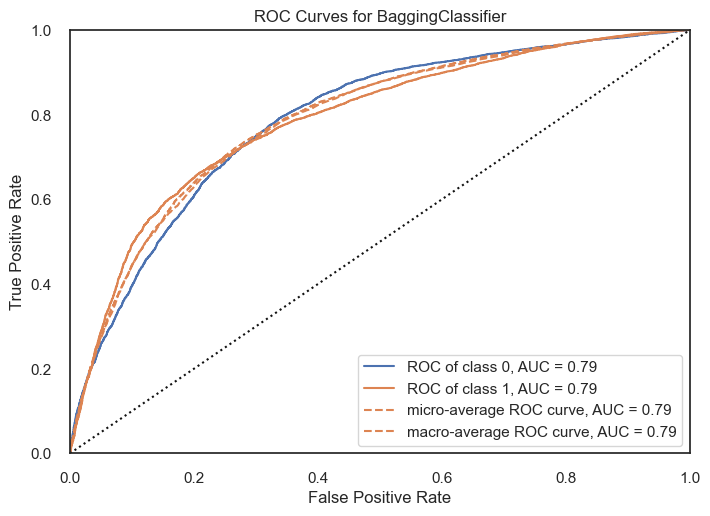

In [21]:
plot_model(best_model, plot="auc")

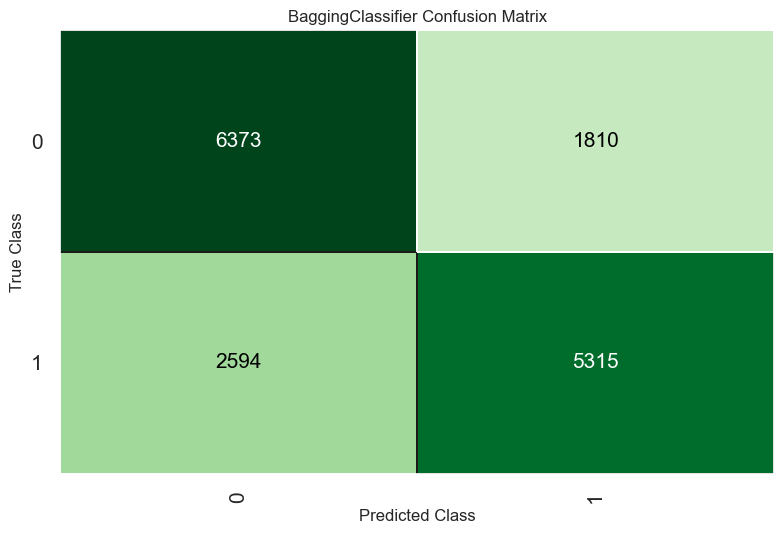

In [31]:
plot_model(best_model, plot="confusion_matrix")

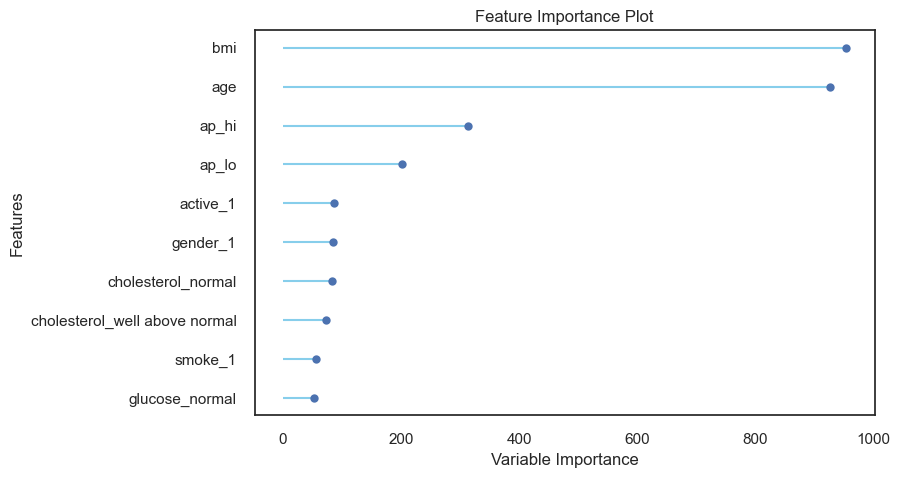

In [24]:
plot_model(top_model, plot = 'feature')

### Predict on test / hold-out Sample

In [46]:
predict_model(best_model);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7263,0.7878,0.6720,0.7460,0.7071,0.4516,0.4537


The accuracy on the test/hold-out set is 0.7263 compared to 0.7271 achieved on the best model CV results. This is not a significant difference. If there is a large variation between the test/hold-out and CV results, then this would normally indicate over-fitting .


### Finalize Model for Deployment
Model finalization is the last step in the experiment. This  leads to the best model for use in making predictions on new and unseen data. The finalize_model function fits the model onto the complete dataset including the test/hold-out sample (30% in this case). The purpose of this function is to train the model on the complete dataset before it is deployed in production.

In [26]:
final_model = finalize_model(best_model)

 ### Prediction on Unseen Data
 The predict_model function is also used to predict on the unseen dataset. data_unseen is the variable contains 10% of the original dataset which was never exposed to PyCaret. 

In [27]:
predict_unseen = predict_model(final_model, data=data_unseen)
predict_unseen


,age,gender,ap_hi,ap_lo,cholesterol,smoke,alco,active,bmi,glucose,Label,Score
0,47.8,1,100,60,normal,0,0,0,23.0,normal,0,0.8213
1,61.8,0,130,90,well above normal,0,0,1,30.0,well above normal,1,0.7722
2,45.9,1,110,70,normal,0,0,1,20.8,well above normal,0,0.8412
3,59.6,0,120,70,normal,1,0,1,21.3,normal,0,0.7466
4,45.5,1,150,90,well above normal,0,0,1,23.5,normal,1,0.8801
...,...,...,...,...,...,...,...,...,...,...,...,...
5955,46.1,1,120,79,normal,0,0,1,26.6,normal,0,0.7499
5956,48.5,0,110,80,normal,0,1,0,24.7,normal,0,0.7828
5957,49.1,0,120,80,normal,0,0,1,28.3,normal,0,0.7220
5958,60.2,1,110,70,normal,0,0,1,23.0,normal,0,0.6966


### Saving Model 

In [28]:
from datetime import date
PATH="../Models/"
save_model(final_model, PATH+"models-v3-"+date.today().strftime("%m-%d-%Y"))

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='cardio',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_stra...
                                                                              min_weight_fraction_leaf=0.0,
                                                                              n_estimators=120,
                                                                      